In [1]:
# notebooks/01_synthetic_data_demo.ipynb

import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Generate 1000 samples
n = 1000
X = np.random.normal(0, 1, (n, 5))  # 5 features
treatment = np.random.binomial(1, 0.5, n)  # 50% treated, 50% control

# True treatment effect: increases outcome by 5
baseline = X[:, 0] + 0.5 * X[:, 1]  # Outcome depends on first two features
outcome = baseline + treatment * 5 + np.random.normal(0, 1, n)

# Create a dataframe
data = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(5)])
data["treatment"] = treatment
data["outcome"] = outcome

data.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,treatment,outcome
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,0,0.884906
1,-0.234137,1.579213,0.767435,-0.469474,0.542560,0,2.653691
2,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,0,-0.834365
3,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,0,-0.477567
4,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0,1.245789


In [3]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Generate 1000 samples with 5 features
n = 1000
X = np.random.normal(0, 1, (n, 5))
treatment = np.random.binomial(1, 0.5, n)

# Create outcome with treatment effect
baseline = X[:, 0] + 0.5 * X[:, 1]
outcome = baseline + treatment * 5 + np.random.normal(0, 1, n)

# Create dataframe
df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(5)])
df["treatment"] = treatment
df["outcome"] = outcome

# Save to CSV
df.to_csv("../data/synthetic.csv", index=False)
print("✅ synthetic.csv saved!")


✅ synthetic.csv saved!


In [6]:
# S-Learner
# 1. Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from econml.sklearn_extensions.model_selection import GridSearchCVList
from econml.metalearners import SLearner, TLearner, XLearner

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load synthetic data
data = pd.read_csv("../data/synthetic.csv")

X = data[[f"feature_{i}" for i in range(5)]]
T = data["treatment"]
y = data["outcome"]

# Split into train/test
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T, y, test_size=0.2, random_state=42)



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


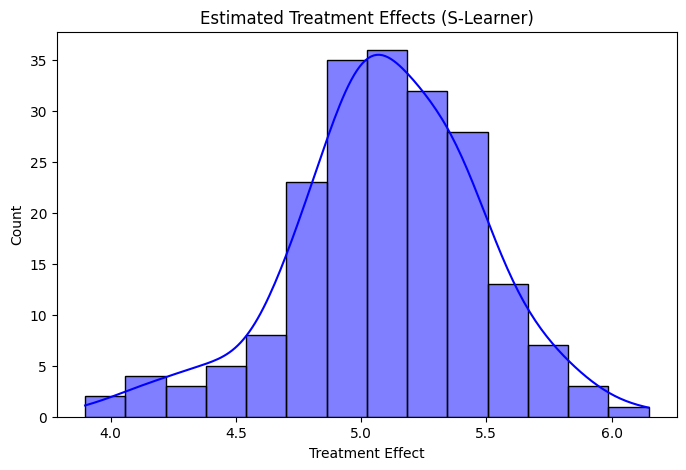

In [7]:
# S-Learner
model = GradientBoostingRegressor()
s_learner = SLearner(overall_model=model)

s_learner.fit(y_train, T_train, X=X_train)

te_preds = s_learner.effect(X_test)

plt.figure(figsize=(8,5))
sns.histplot(te_preds, kde=True, color="blue")
plt.title("Estimated Treatment Effects (S-Learner)")
plt.xlabel("Treatment Effect")
plt.show()


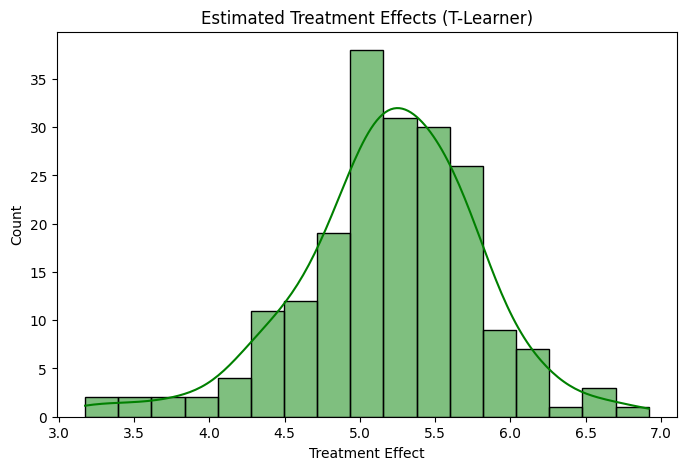

In [8]:
# T-Learner
t_learner = TLearner(models=[GradientBoostingRegressor(), GradientBoostingRegressor()])
t_learner.fit(y_train, T_train, X=X_train)

te_preds_t = t_learner.effect(X_test)

plt.figure(figsize=(8,5))
sns.histplot(te_preds_t, kde=True, color="green")
plt.title("Estimated Treatment Effects (T-Learner)")
plt.xlabel("Treatment Effect")
plt.show()


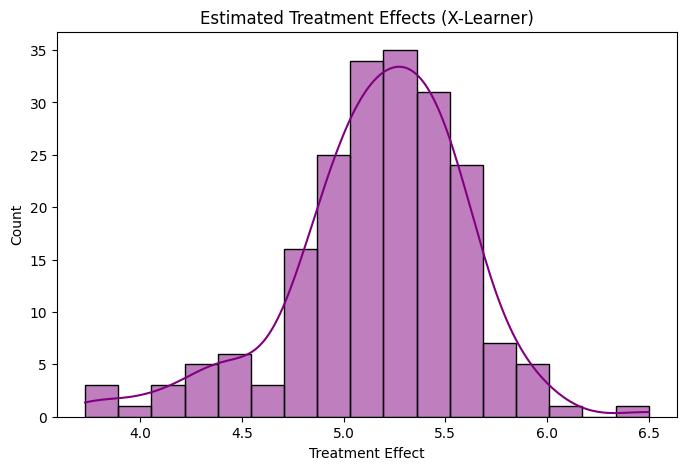

In [9]:
# X-Learner
x_learner = XLearner(models=[GradientBoostingRegressor(), GradientBoostingRegressor()])
x_learner.fit(y_train, T_train, X=X_train)

te_preds_x = x_learner.effect(X_test)

plt.figure(figsize=(8,5))
sns.histplot(te_preds_x, kde=True, color="purple")
plt.title("Estimated Treatment Effects (X-Learner)")
plt.xlabel("Treatment Effect")
plt.show()


In [12]:
from econml.metalearners import SLearner
from sklearn.ensemble import GradientBoostingRegressor

def train_s_learner(X_train, T_train, y_train):
    model = GradientBoostingRegressor()
    s_learner = SLearner(overall_model=model)
    s_learner.fit(y_train, T_train, X=X_train)
    return s_learner

In [18]:
# ---- SHAP EXPLANATION ----
%pip install causalml




[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
from causalml.inference.meta import BaseSClassifier
from sklearn.ensemble import GradientBoostingClassifier
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate synthetic classification data
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=5, random_state=42)
treatment = np.random.binomial(1, 0.5, size=1000)

# Train S-Learner (binary uplift classification)
s_learner = BaseSClassifier(learner=GradientBoostingClassifier())
s_learner.fit(X=X, treatment=treatment, y=y)

# Get internal model (trained on combined data)
model = s_learner.model

# Run SHAP
explainer = shap.Explainer(model.predict_proba, X)
shap_values = explainer(X)

# Plot SHAP feature importance
shap.summary_plot(shap_values[:,:,1], X, plot_type="bar")


NotFittedError: This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.